In [4]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
from einops import rearrange

In [5]:
dataset = torch.load("../data/full.pt")

/tmp/ipykernel_7946/864981642.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load("../data/full.pt")


In [7]:
import torch
import torch.nn as nn
from einops import rearrange
import lightning as L
import torch.optim as optim
from rotary_embedding_torch import RotaryEmbedding

class RevIN(nn.Module):
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.cached_mean = None
        self.cached_std = None

    def forward(self, x, mode: str):
        assert x.dim() == 3, "Input tensor must be (batch, n_patches, patch_len)"

        # Cast to float64 for stable statistics computation
        x64 = x.double()

        if mode == "norm":
            mean, std = self._get_statistics(x64)
            self.cached_mean, self.cached_std = mean.detach(), std.detach()
            out = (x64 - mean) / std

        elif mode == "denorm":
            assert self.cached_mean is not None and self.cached_std is not None, \
                "Call forward(..., 'norm') before 'denorm'"
            out = x64 * self.cached_std + self.cached_mean

        else:
            raise NotImplementedError(f"Mode '{mode}' not implemented.")

        # Convert back to float32 for compatibility with main model
        return out.float()

    def _get_statistics(self, x):
        """
        Numerically stable mean and variance computation using 
        incremental mean and variance along the patch dimension.
        x: (B, P, L) float64
        Returns: mean, std (both (B, P, 1))
        """
        B, P, L = x.shape
        counts = torch.arange(1, P+1, device=x.device).view(1, P, 1) * L

        # Incrementally compute mean
        cumsum_x = torch.cumsum(x.sum(dim=-1, keepdim=True), dim=1)
        mean = cumsum_x / counts

        # Variance: mean of squared deviations from the mean
        # Efficient incremental formula:
        # var_i = (sum(x^2) - 2*mean*sum(x) + count*mean^2)/count
        cumsum_x2 = torch.cumsum((x**2).sum(dim=-1, keepdim=True), dim=1)
        var = (cumsum_x2 - 2 * mean * cumsum_x + counts * mean**2) / counts
        std = torch.sqrt(var + self.eps)

        return mean, std

class ResidualBlock(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden_layer = nn.Linear(in_dim, hid_dim)
        self.output_layer = nn.Linear(hid_dim, out_dim)
        self.residual_layer = nn.Linear(in_dim, out_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        hid = self.act(self.hidden_layer(x))
        out = self.output_layer(hid)
        res = self.residual_layer(x)
        out = out+res
        return out
    
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model%n_heads==0, f"d_model ({d_model}) must be divisible by n_heads ({n_heads})"

        self.WQ = nn.Linear(d_model, d_model)
        self.WK = nn.Linear(d_model, d_model)
        self.WV = nn.Linear(d_model, d_model)

        self.out_proj = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

        self.head_dim = d_model//n_heads
        self.n_heads = n_heads

        self.rope = RotaryEmbedding(dim=self.head_dim//2)
    
    def forward(self, q):
        bs, context, dim = q.size()

        k = q
        v = q

        q = self.WQ(q).reshape(bs, -1, self.n_heads, self.head_dim).transpose(1, 2)
        k = self.WK(k).reshape(bs, -1, self.n_heads, self.head_dim).transpose(1, 2)
        v = self.WV(v).reshape(bs, -1, self.n_heads, self.head_dim).transpose(1, 2)

        q  = self.rope.rotate_queries_or_keys(q)
        k = self.rope.rotate_queries_or_keys(k)

        attn_weights = q @ k.transpose(2, 3) * self.head_dim**(-1/2)

        mask = torch.triu(torch.ones(attn_weights.size(-2), attn_weights.size(-1)), diagonal=1).bool().to(attn_weights.device)
        attn_weights = attn_weights.masked_fill(mask, float('-inf'))
        scores = torch.nn.functional.softmax(attn_weights, dim=-1)

        scores = self.dropout(scores)

        values = scores @ v

        values = values.transpose(1, 2).reshape(bs, -1, dim)
        values = self.out_proj(values)
        return values, (scores, v)
    
class FeedForward(nn.Module):
    def __init__(self, d_model, dropout=0.1, multiple_of=256):
        super().__init__()

        hidden_dim = d_model*4
        hidden_dim = int(2 * hidden_dim / 3)
        hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)

        self.w1 = nn.Linear(d_model, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, d_model, bias=False)
        self.w3 = nn.Linear(d_model, hidden_dim, bias=False)

        self.act = nn.SiLU()
        self.dp = nn.Dropout(dropout)

    def forward(self, x):
        x = self.w2(self.act(self.w1(x)) * self.w3(x))
        return self.dp(x)


class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout=dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model=d_model, dropout=dropout)
    
    def forward(self, x):
        out_attn, (scores, v) = self.attn(self.ln1((x)))
        x = x + out_attn
        out = x + self.ff(self.ln2(x))
        return out, (out_attn, scores, v)
    
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                TransformerEncoderLayer(d_model=d_model, n_heads=n_heads, dropout=dropout)
                for _ in range(n_layers)
            ]
        )
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        history = []
        for layer in self.layers:
            x, (out_attn, scores, v) = layer(x)
            history.append((x, out_attn, scores, v))
        return self.norm(x), history

class PatchFM(nn.Module): 
    def __init__(self, seq_len, patch_len, d_model, n_heads, n_layers_encoder, dropout=0.1, quantiles=None):
        super().__init__()
        assert seq_len%patch_len==0, f"seq_len ({seq_len}) should be divisible by patch_len ({patch_len})"
        
        self.seq_len = seq_len
        self.patch_len = patch_len

        self.quantiles = quantiles if quantiles is not None else [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        self.n_quantiles = len(self.quantiles)

        self.revin = RevIN()

        self.proj_embedding = ResidualBlock(in_dim=patch_len, hid_dim=2*patch_len, out_dim=d_model, dropout=dropout)
        self.dp = nn.Dropout(dropout)
        self.transformer_encoder = TransformerEncoder(d_model=d_model, n_heads=n_heads, n_layers=n_layers_encoder, dropout=dropout)

        self.proj_output = ResidualBlock(in_dim=d_model, hid_dim=2*d_model, out_dim=patch_len * self.n_quantiles, dropout=dropout)
        #self.proj_output = ResidualBlock(in_dim=d_model, hid_dim=2*d_model, out_dim=patch_len, dropout=dropout)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                m.bias.data.fill_(0.0)
                m.weight.data.fill_(1.0)
    
    def forward(self, x): 
        bs, ws = x.size()

        x = rearrange(x, "b (pn pl) -> b pn pl", pl=self.patch_len)  # Reshape to (bs, patch_num, patch_len)
        x_patched = x.clone()  # Keep a copy of the patched input for later concatenation
        x = self.revin(x, mode="norm")
        x_patched_normalized = x.clone()  # Keep a copy of the normalized patched input

        x = self.proj_embedding(x) # bs, pn, d_model
        x = self.dp(x)
        x, history = self.transformer_encoder(x) # bs, pn, d_model
        outt = x.clone()

        forecasting = self.proj_output(x)  # bs, pn, patch_len * n_quantiles
        x_forecasted = forecasting.clone()  # Keep a copy of the forecasted output for later concatenation

        forecasting = self.revin(forecasting, mode="denorm")

        forecasting = rearrange(forecasting, "b pn (pl q) -> b pn pl q", pl=self.patch_len, q=self.n_quantiles)  # Reshape to (bs, patch_len, n_quantiles)
        x_forecasted_denormalized = forecasting.clone()  # Keep a copy of the denormalized forecasted output

        return forecasting, x_patched, x_patched_normalized, x_forecasted, x_forecasted_denormalized, history, outt
    
class MultiQuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()

        if not isinstance(quantiles, torch.Tensor):
            quantiles = torch.tensor(quantiles)

        assert all(0 < q < 1 for q in quantiles), "Quantiles must be in the range (0, 1)"
        self.quantiles = quantiles

    def forward(self, pred, target):
        assert pred.shape[-1] == len(self.quantiles)
        assert target.shape[1] == pred.shape[1] # n_patches
        assert target.shape[2] == pred.shape[2] # patch_len
        self.quantiles = self.quantiles.to(pred.device)
        target = target.unsqueeze(-1) 
        errors = target - pred
        losses = torch.max((self.quantiles - 1) * errors, self.quantiles * errors)
        return losses.mean()

class PatchFMLit(L.LightningModule):
    def __init__(self, config):
        super().__init__()
        
        assert config.epochs >= config.epochs_warmups, "epochs must be greater than epochs_warmups"
        assert config.n_warmups > 0, "n_warmups must be greater than 0"
        assert config.epochs_warmups % config.n_warmups == 0, "number of warmups epochs must be divisible by n_warmups"

        self.model = PatchFM(
            seq_len=config.ws, 
            patch_len=config.patch_len, 
            d_model=config.d_model, 
            n_heads=config.n_heads, 
            n_layers_encoder=config.n_layers_encoder, 
            dropout=config.dropout, 
            quantiles=config.quantiles
        )

        self.criterion = MultiQuantileLoss(self.model.quantiles)
        
        self.ctx = [config.ws // config.n_warmups * i for i in range(1, config.n_warmups + 1)]
        self.n_epochs = config.epochs_warmups // config.n_warmups

        self.save_hyperparameters(config)

    def training_step(self, batch, batch_idx):
        x, y = batch

        current_epoch = self.current_epoch
        ctx = self.ctx[current_epoch // self.n_epochs if current_epoch < len(self.ctx) * self.n_epochs else -1]
        x = x[:, -ctx:]

        prediction, x_patch = self.model(x)
        if torch.isnan(prediction).any():
            raise ValueError("NaN values found in model predictions")
        y = y.unsqueeze(1)
        y = torch.cat([x_patch, y], dim=1)    
        loss = self.criterion(prediction, y)
        self.log("train_loss", loss, sync_dist=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, betas=(0.9, 0.98), eps=1e-9, weight_decay=1e-6)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.epochs, eta_min=0)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

model = PatchFMLit.load_from_checkpoint("../ckpts/patchfm_150_80wu4_256.ckpt")
model.eval()

/home/svilhes/anaconda3/envs/anots/lib/python3.11/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.3.3


PatchFMLit(
  (model): PatchFM(
    (revin): RevIN()
    (proj_embedding): ResidualBlock(
      (dropout): Dropout(p=0.15, inplace=False)
      (hidden_layer): Linear(in_features=32, out_features=64, bias=True)
      (output_layer): Linear(in_features=64, out_features=1024, bias=True)
      (residual_layer): Linear(in_features=32, out_features=1024, bias=True)
      (act): ReLU()
    )
    (dp): Dropout(p=0.15, inplace=False)
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attn): MultiHeadAttention(
            (WQ): Linear(in_features=1024, out_features=1024, bias=True)
            (WK): Linear(in_features=1024, out_features=1024, bias=True)
            (WV): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.15, inpl

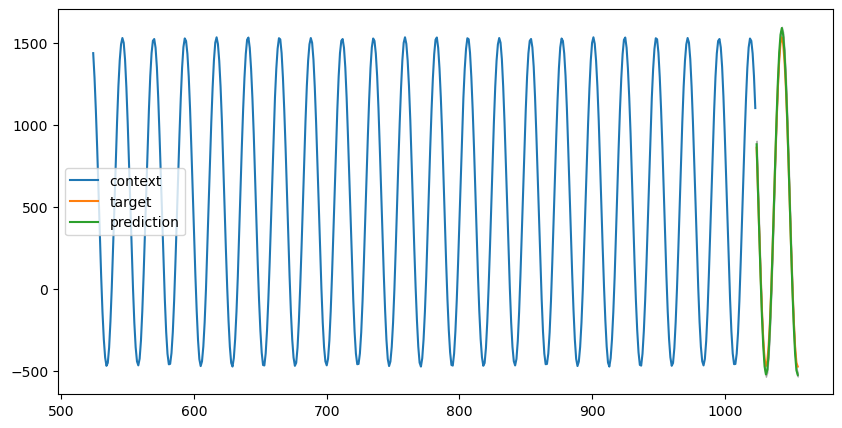

In [8]:
idx = random.randint(0, len(dataset))
input, target = dataset[idx]

context = input.clone()

input = input.unsqueeze(0).to('cuda')
with torch.no_grad():
  prediction, x_patched, x_patched_normalized, x_forecasted, x_forecasted_denormalized, history, outt = model.model(input)
prediction = prediction[0, -1, :, :].detach().cpu().numpy()

median = prediction[:, list(model.model.quantiles).index(0.5)]
lower = prediction[:, list(model.model.quantiles).index(0.1)]
upper = prediction[:, list(model.model.quantiles).index(0.9)]

plt.figure(figsize=(10, 5))

plt.plot(range(len(context))[-500:], context[-500:], label="context")
plt.plot(range(len(context), len(context)+len(target)), target, label="target")

plt.plot(range(len(context), len(context)+len(target)), median, label="prediction")
plt.fill_between(range(len(context), len(context)+len(target)), lower, upper, color="grey", alpha=0.6)

plt.legend()

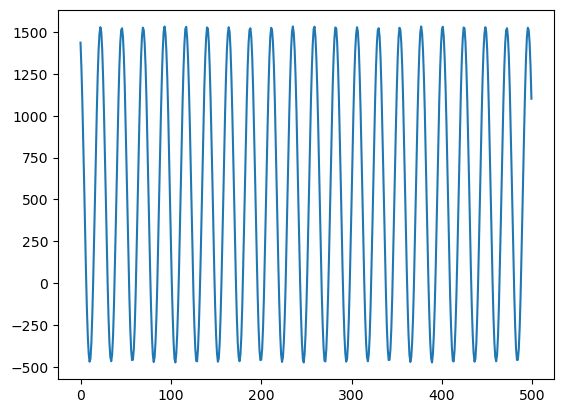

In [9]:
plt.plot(x_patched.flatten().detach().cpu().numpy()[-500:])

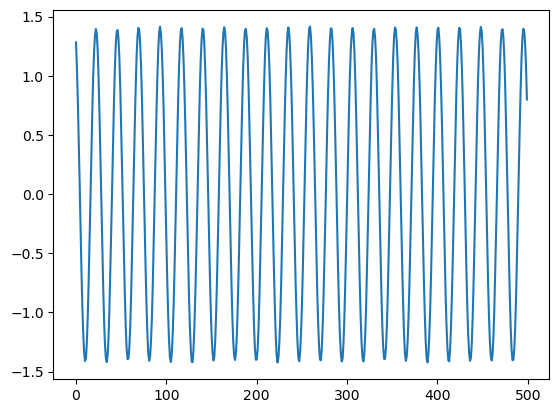

In [10]:
plt.plot(x_patched_normalized.flatten().detach().cpu().numpy()[-500:])

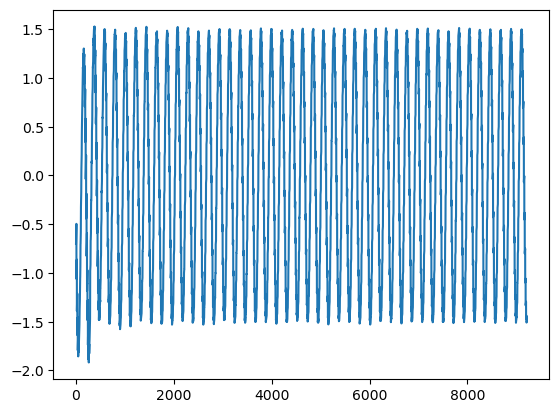

In [11]:
plt.plot(x_forecasted.flatten().detach().cpu().numpy())

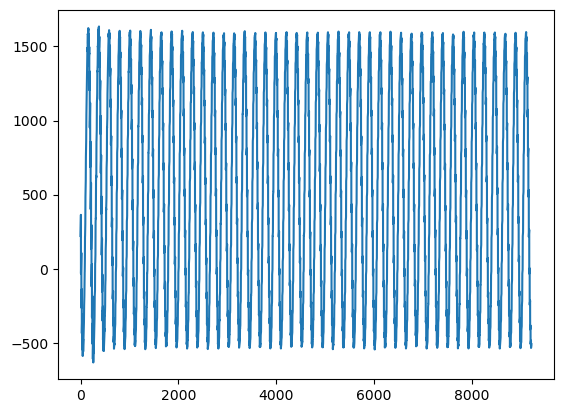

In [12]:
plt.plot(x_forecasted_denormalized.flatten().detach().cpu().numpy())

<Axes: >

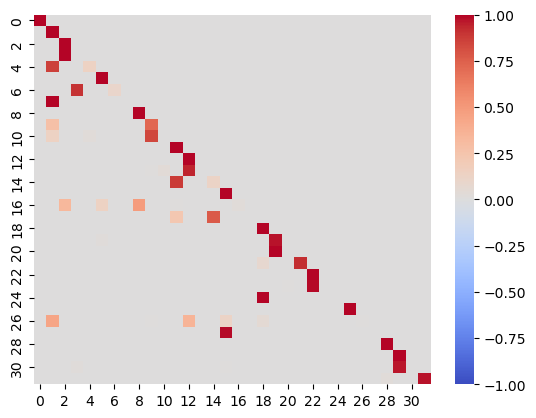

In [13]:
x, out, scores, v = history[0]

scores_head0 = scores[0, 31, :, :].detach().cpu().numpy()
sns.heatmap(scores_head0, cmap="coolwarm", center=0, vmin=-1, vmax=1)